# Links
 - Comment on sympy: https://stackoverflow.com/questions/43197704
 - HGP: https://aip.scitation.org/doi/pdf/10.1063/1.455553
 - libreta
  - Paper: https://pubs.acs.org/doi/10.1021/acs.jctc.7b00788
  - SI: https://pubs.acs.org/doi/suppl/10.1021/acs.jctc.7b00788/suppl_file/ct7b00788_si_001.pdf

In [1]:
import sympy as sym

sym.init_printing()

In [2]:
# Centers
A0, A1, A2, B0, B1, B2, C0, C1, C2, D0, D1, D2 = sym.symbols("A:3 B:3 C:3 D:3")
A0, A1, A2, B0, B1, B2, C0, C1, C2, D0, D1, D2

In [3]:
# Angular momenta
a0, a1, a2, b0, b1, b2, c0, c1, c2, d0, d1, d2 = sym.symbols("a:3 b:3 c:3 d:3")
a0, a1, a2, b0, b1, b2, c0, c1, c2, d0, d1, d2

In [4]:
# Exponents
alpha, beta, gamma, delta = sym.symbols("alpha beta gamma delta")
alpha, beta, gamma, delta

In [5]:
class Primitive:
    
    ang_moms_strs = {
        0: "s",
        1: "p",
        2: "d",
        3: "f",
        4: "g",
        5: "h",
        6: "i",
        7: "j",
        8: "k",
    }
    
    def __init__(self, ang_mom, exponent, center):
        self.ang_mom = ang_mom
        self.exp = exponent
        self.center = sym.Matrix(3, 1, center)
    
    @property
    def tot_ang_mom(self):
        return sum(self.ang_mom)
    
    @property
    def exp_center(self):
        return self.exp * self.center
    
    def total_exponent(self, primB):
        """Eq. (9.2.11), p. 341"""
        return self.exp + primB.exp
       
    def reduced_exponent(self, primB):
        """Eq. (9.2.12), p. 341"""
        return (self.exp * primB.exp) / self.total_exponent(primB)
    
    def center_of_charge(self, primB):
        """Eq. (9.2.13), p. 341"""
        return (self.exp_center + primB.exp_center) / self.total_exponent(primB)
    
    def relative_coordinate(self, primB):
        """Eq. (9.2.14), p. 341"""
        return self.center - primB.center
    
    def separation(self, primB):
        return self.relative_coordinate(primB).norm()
    
    def pre_exponential_factor(self, primB):
        """Eq. (9.2.15), p. 341"""
        return sym.exp(-self.reduced_exponent(primB) * self.separation(primB))
    
    def dec_ang_mom(self, index, dec_by=1):
        ang_mom = list(self.ang_mom)
        ang_mom[index] -= dec_by
        if ang_mom[index] < 0:
            return 0
        return Primitive(ang_mom, self.exp, self.center)
    
    def inc_ang_mom(self, index, inc_by=1):
        ang_mom = list(self.ang_mom)
        ang_mom[index] += inc_by
        return Primitive(ang_mom, self.exp, self.center)
    
    def __str__(self):
        return self.ang_moms_strs[self.tot_ang_mom]
    
    def __repr__(self):
        return f"Primitive({self.amom}, {self.exp}, {tuple(self.center)})"


primA = Primitive((a0, a1, a2), alpha, (A0, A1, A2))
primB = Primitive((b0, b1, b2),  beta, (B0, B1, B2))
primC = Primitive((c0, c1, c2), gamma, (C0, C1, C2))
primD = Primitive((d0, d1, d2), delta, (D0, D1, D2))

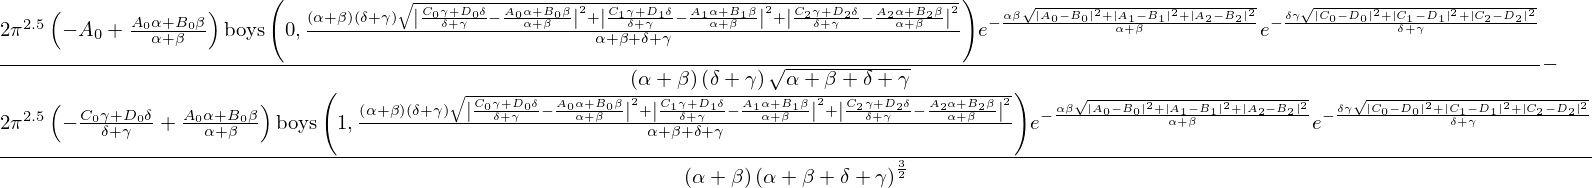

In [6]:
boys = sym.Function("boys")

class pERI(sym.Function):
    
    no_eval = True
    
    def __init__(self, primA, primB, primC, primD, N=0):
        self.primA = primA
        self.primB = primB
        self.primC = primC
        self.primD = primD
        
        self.N = 0
    
    @property
    def P(self):
        return self.primA.center_of_charge(self.primB)
    
    @property
    def Q(self):
        return self.primC.center_of_charge(self.primD)
    
    @property
    def zeta(self):
        return self.primA.total_exponent(self.primB)
    
    @property
    def eta(self):
        return self.primC.total_exponent(self.primD)

    @property
    def prims(self):
        return [self.primA, self.primB, self.primC, self.primD]
    
    def dec_ang_mom(self, prim_ind, ind, dec_by, N_new):
        prims = self.prims.copy()
        prims[prim_ind] = prims[prim_ind].dec_ang_mom(ind, dec_by)
        # Check if any of the total angular momenta became < 0; if so the primitive
        # will be 0 and we just return 0.
        if any([prim == 0 for prim in prims]):
            return 0

        if sum([prim.tot_ang_mom for prim in prims]) == 0:
            return self.base_integral(N_new)
        return pERI(*prims, N_new)
    
    def inc_ang_mom(self, prim_ind, ind, inc_by, N_new):
        prims = self.prims.copy()
        prims[prim_ind] = prims[prim_ind].inc_ang_mom(ind, inc_by)
        return pERI(*prims, N_new)

    def base_integral(self, N):
        if N < 0:
            return 0

        zeta = self.zeta
        eta = self.eta
        T = (zeta * eta) / (zeta + eta) * (self.P - self.Q).norm()
    
        Kab = self.primA.pre_exponential_factor(self.primB)
        Kcd = self.primC.pre_exponential_factor(self.primD)
        return 2 * sym.pi**(5/2) / (zeta * eta * sym.sqrt(zeta + eta)) * Kab * Kcd * boys(N,T)
    
    def vrr1(self, ind):
        bra_prim_ind = 0  # primA
        ket_prim_ind = 2  # primC
        
        X_PA = (self.P - self.primA.center)[ind]
        X_PQ = (self.P - self.Q)[ind]
        zeta = self.zeta
        eta = self.eta
        N = self.N
        zeta_eta = zeta + eta
        quot = eta / zeta_eta
        
        bra_ang_mom = self.prims[bra_prim_ind].ang_mom[ind]
        ket_ang_mom = self.prims[ket_prim_ind].ang_mom[ind]
        
        return (
            X_PA * self.dec_ang_mom(bra_prim_ind, ind, 1, N)
            - quot * X_PQ * self.dec_ang_mom(bra_prim_ind, ind, 1, N + 1)
            + bra_ang_mom / (2 * zeta) * (
                self.dec_ang_mom(bra_prim_ind, ind, 2, N)
                - quot * self.dec_ang_mom(ket_prim_ind, ind, 2, N + 1)
            ) + ket_ang_mom / (2 * zeta_eta) * self.dec_ang_mom(ket_prim_ind, ind, 1, N + 1)
        )

    def __str__(self):
        la, lb, lc, ld = [str(prim) for prim in (self.primA, self.primB, self.primC, self.primD)]
        return f"[{la}{lb}|{lc}{ld}]"

l0 = (0, 0, 0)

sA = Primitive(l0, alpha, (A0, A1, A2))
sB = Primitive(l0,  beta, (B0, B1, B2))
sC = Primitive(l0, gamma, (C0, C1, C2))
sD = Primitive(l0, delta, (D0, D1, D2))
ssss = pERI(sA, sB, sC, sD)
#print(ssss)

lpx = (1, 0, 0)
pA = Primitive(lpx, alpha, (A0, A1, A2))
psss = pERI(pA, sB, sC, sD)
#print(psss)

psss_vrr1 = psss.vrr1(0)
psss_vrr1

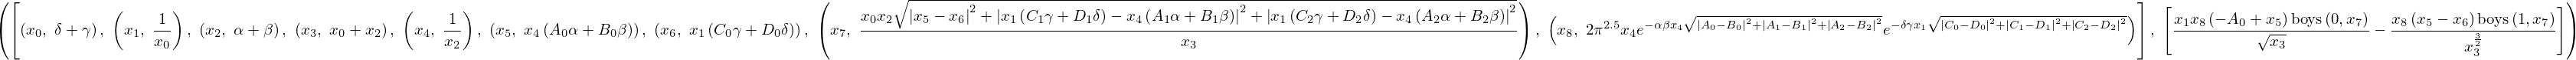

In [8]:
sym.cse(psss_vrr1)

def gen_cse_code(name, expr):
    generator = CCodeGen(cse=True)
    expr_tpl = (name, expr)
    if isinstance(expr, list):
        if len(expr) > 1:
            res = MatrixSymbol("res", len(expr), 1)
            expr_tpl = (name, [Equality(res, Matrix(expr))])
        else:
            expr_tpl = (name, expr[0])
    [(c_name, c_code), (h_name, c_header)]  = codegen(expr_tpl, code_gen=generator, header=False, empty=False)
    return c_name, c_code


def print_cse_code(name, expr):
    c_name, c_code = gen_cse_code(name, expr)
    print(c_name)
    print()
    print(c_code)


print_cse_code("psss", psss_vrr1)